In [1]:
import argparse
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
import json

from nn.enums import ExplainingMethod
from nn.networks import ExplainableNet
from nn.utils import get_expl, plot_overview, clamp, load_image, make_dir
from nn.utils import gini_tensor, load_numpy, load_image_nopreprocess, show_expl
from nn.utils import gini_numpy, gini_tensor2, gini_tensor_ori, gini_tensor_double
from nn.utils import torch_to_image_ver2, png_to_jpeg, heatmap_to_image
from nn.utils import get_center_attack_matrix, show_expl_title, topk_intersection, show_expl_title_return_im
import samples.samples as DS
from models.mytool import * # 切換 model 的 function 跟 get_beta
import re #正規表達式 lib
from nn.imagetool import * # 印各種圖片(灰階 熱點)
import saliency.core as saliency
from PIL import Image
from matplotlib import pylab as P
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from skimage.measure import compare_ssim
from scipy.stats import pearsonr
torch.set_printoptions(precision=7) # tensor 小數點後7位
%matplotlib inline 
#要加這一行才有辦法直接用 imshow印出圖片 且只要加一次 所以加在最前面

no display found. Using non-interactive Agg backend


### 基本設定

In [2]:
#from mytool import set_parameter_requires_grad
DATASET = 'imagenet'
MODEL = 'VGG16' # ['RESNET50','_DENSENET121','VGG16','INCEPTIONV3','MOBILENETV2']
img_number = 100
size = 224 #299 # 改變圖片大小 cifar10 原本是32x32
#""""""""""""""""""""""""""""""""""
# resnet 224
# alexnet 224
# vgg 224
# squeezenet 224
# mobilenet 224
# densenet 224
# inception 299
#""""""""""""""""""""""""""""""""""
config_path = '/tf/XAI_Attack/config/model_config.json'
config = json.load(open(config_path))['{}_{}_{}'.format('torch', MODEL, DATASET)]
#label_dict = getattr(dataset_label, DATASET)
#model_types = re.findall("^([a-z]+)", config['model'])[0]
nb_classes = config['label']
# model_tsai = TORCH_MODEL(model_name = MODEL, dataset = DATASET, gpu = torch.cuda.is_available())
ds = getattr(DS, DATASET)
print('ds type: ',type(ds))
print('ds[0] type: ',type(ds[0]),ds[0])
indices = torch.randperm(len(ds.targets))[:img_number].numpy().astype(int) #隨機抽 img_number 張圖
images_list, labels = [np.array(ds[i][0].resize((size,size)).convert('RGB')) for i in indices], [np.array(ds[i][1]) for i in indices]
print('images_list type:',type(images_list))
images_arr, labels = np.array(images_list).astype('float32'), np.array(labels)
print('images_arr type:',type(images_arr),images_arr.shape)
labels_torch = torch.from_numpy(labels)

images = torch.tensor(images_arr)
print('images:',type(images),images.shape)
print('labels:',labels.shape)
print('model:',MODEL)
print('dataset:',DATASET)

ds type:  torchvision.datasets.imagenet.ImageNet
ds[0] type:  <class 'tuple'> (<PIL.Image.Image image mode=RGB size=500x375 at 0x7F3A60145EB8>, 0)
images_list type: <class 'list'>
images_arr type: <class 'numpy.ndarray'> (100, 224, 224, 3)
images: <class 'torch.Tensor'> torch.Size([100, 224, 224, 3])
labels: (100,)
model: VGG16
dataset: imagenet


### 讀取圖片

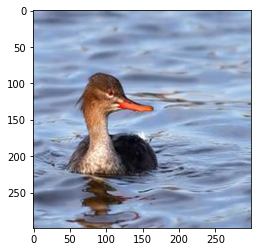

In [3]:
num_iter = 600
#img = 'data/collie4.jpeg' #要攻擊的圖
#img = 'good_images/example_627_ver2/x.jpeg'
case = '0'
exp_method = 'lrp' #  choices=['lrp', 'guided_backprop', 'gradient', 'integrated_grad', 'pattern_attribution', 'grad_times_input']
#img = 'tmp_image/'+case+'.jpeg'
img = 'tmp_image/'+case+'.jpeg'
#img = 'temp_result/case_'+case+'.jpeg'

red = 'nn/RED.jpeg'
lr = 0.0002
cuda = True
output_dir = 'temp_result/'
beta_growth = True
prefactors = [1e4, 1e10, 1e-4] # 4 10 -4
device = torch.device("cuda" if cuda else "cpu")
method = getattr(ExplainingMethod, exp_method)
# 確認實驗的圖片
im_orig = LoadImage(img)
P.imshow(im_orig)

### 讀取model

In [4]:
# load model
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
vgg_model = torchvision.models.vgg16(pretrained=True)
#vgg_model = torchvision.models.alexnet(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if beta_growth else None)
#if method == ExplainingMethod.pattern_attribution:
#    model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
model = model.eval().to(device)


#x_target = load_image(data_mean, data_std, device, target_img)


# load images
x = load_image(data_mean, data_std, device, img)
#x = load_image_nopreprocess(data_mean, data_std, device, img)


x_adv = x.clone().detach().requires_grad_()
print('x',x.shape,type(x))
print('x range',x.min(),x.max())
print('x_adv',x_adv.shape,type(x_adv))
print('x_adv range',x_adv.min(),x_adv.max())

# produce expls
org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()
#target_expl, _, _ = get_expl(model, x_target, method)
#target_expl = target_expl.detach()

# target attack
target_mtx = get_center_attack_matrix(200, 200, 35, org_expl, 224)
target_mtx_torch = torch.tensor(target_mtx)
target_mtx_torch = target_mtx_torch.view(1,224,224)
target_mtx_torch = target_mtx_torch.to(device)
target_mtx_torch = target_mtx_torch.float()
optimizer = torch.optim.Adam([x_adv], lr=lr)


x torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>
x range tensor(-2.1179039, device='cuda:0') tensor(2.6400001, device='cuda:0')
x_adv torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>
x_adv range tensor(-2.1179039, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.6400001, device='cuda:0', grad_fn=<MaxBackward1>)


### 先用實驗模型預測單張樣本

im2.shape:  (224, 224, 3)
im_orig:  (224, 224, 3) <class 'numpy.ndarray'>
im_tensor torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>
im_tensor range tensor(-2.1179039, grad_fn=<MinBackward1>) tensor(2.6400001, grad_fn=<MaxBackward1>)


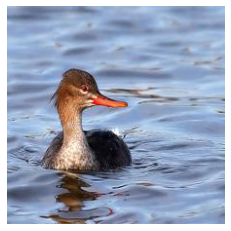

In [5]:

im = Image.open(img)
im2 = np.array(im)
im2 = im2.astype(np.float64)
im_orig = im2 #  (224,224,3) 而且這裡的是小數化的整數表示，沒有經過data_mean跟data_sta前處理的
print('im2.shape: ',im2.shape)
im_tensor = PreprocessImages([im_orig])
# Show the image
im_orig_int = np.int_(im_orig) #要從float轉成int才有辦法用ShowImage印出來
ShowImage(im_orig_int)
print('im_orig: ',im_orig.shape, type(im_orig)) # im_orig:  (299, 299, 3) <class 'numpy.ndarray'>
print('im_tensor',im_tensor.shape,type(im_tensor))
print('im_tensor range',im_tensor.min(),im_tensor.max())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
im_tensor = im_tensor.to(device)


In [6]:

predictions = model(im_tensor)
predictions = predictions.cpu().detach().numpy()
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236
origin_prediction_class = prediction_class
im = im_orig.astype(np.float32)
print('im: ',im.shape, type(im)) # im:  (299, 299, 3) <class 'numpy.ndarray'>
print('ori_image')
value_sort = np.sort(predictions[0])[::-1]
print(value_sort[:2][0], value_sort[:2][1])
score_diff = value_sort[:2][0] - value_sort[:2][1]
print('dump score diff:',score_diff)

Prediction class: 98
im:  (224, 224, 3) <class 'numpy.ndarray'>
ori_image
33.20144 21.32517
dump score diff: 11.876268


In [7]:
value_sort = np.sort(predictions[0])[::-1]
index_sort = np.argsort(predictions[0])[::-1]
for i in range(5):
    print('label: ',index_sort[:5][i], ' score: ',value_sort[:5][i])

label:  98  score:  33.20144
label:  97  score:  21.32517
label:  141  score:  20.724054
label:  100  score:  18.996838
label:  137  score:  18.47061


### 攻擊開始

In [8]:
total_loss_list = []
epoch_exp = []
L1_score = []
L2_score = []
L3_score = []
L4_score = []
L5_score = []

early_stop_epoch = 0
mode_2_loss = False
EARLY_STOP = True#False
for i in range(num_iter):
    if beta_growth:
        model.change_beta(get_beta(i, num_iter))

    optimizer.zero_grad()

    # calculate loss
    adv_expl, adv_acc, class_idx = get_expl(model, x_adv, method, desired_index=org_idx)
    loss_center = F.mse_loss(adv_expl, target_mtx_torch)
    loss_output = F.mse_loss(adv_acc[0][prediction_class], org_acc[0][prediction_class].detach())
    #loss_output = F.mse_loss(adv_acc, org_acc.detach())
    if mode_2_loss:
        total_loss = prefactors[0]*loss_output + prefactors[1]*loss_center
    else:
        total_loss = prefactors[0]*loss_output + prefactors[1]*loss_center

    total_loss_list.append(total_loss.item())
    x_tmp = x_adv
    # update adversarial example
    total_loss.backward()
    optimizer.step()
    predictions = model(x_adv)
    predictions = predictions.cpu().detach().numpy()
    if (value_sort[:2][0] - value_sort[:2][1]) < 1 :
        mode_2_loss = True
    #print(i,predictions[0][prediction_class], value_sort[:2][0], value_sort[:2][1])
    L1_score.append(predictions[0][index_sort[:5][0]])
    L2_score.append(predictions[0][index_sort[:5][1]])
    L3_score.append(predictions[0][index_sort[:5][2]])
    L4_score.append(predictions[0][index_sort[:5][3]])
    L5_score.append(predictions[0][index_sort[:5][4]])
    prediction_class_tmp = np.argmax(predictions[0])
    if(prediction_class != prediction_class_tmp):
        print(i,'early done')
        early_stop_epoch = i
        if EARLY_STOP == True:
            x_adv = x_tmp
            break

    x_adv.data = clamp(x_adv.data, data_mean, data_std)
    if i == 1:
        print("Iteration {}: Total Loss: {}, Gini Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_center.item(), loss_output.item()))
    #print("Iteration {}: Total Loss: {}, Expl Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_expl.item(), loss_output.item()))

    if (i+1)%50 == 0:
        print("Iteration {}: Total Loss: {}, Gini Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_center.item(), loss_output.item()))
        epoch_exp.append(adv_expl)
        


Iteration 1: Total Loss: 4975.271484375, Gini Loss: 4.975271394869196e-07, Output Loss: 0.0
Iteration 49: Total Loss: 4962.97265625, Gini Loss: 4.962972752764472e-07, Output Loss: 8.117382321870537e-10
Iteration 99: Total Loss: 4937.560546875, Gini Loss: 4.937371045343752e-07, Output Loss: 1.8929817088064738e-05
Iteration 149: Total Loss: 4895.1376953125, Gini Loss: 4.894237690677983e-07, Output Loss: 9.001170838018879e-05
Iteration 199: Total Loss: 4864.32666015625, Gini Loss: 4.863184699388512e-07, Output Loss: 0.00011421310773584992
Iteration 249: Total Loss: 4844.65234375, Gini Loss: 4.843419105782232e-07, Output Loss: 0.00012332104961387813
Iteration 299: Total Loss: 4828.927734375, Gini Loss: 4.827678594665485e-07, Output Loss: 0.00012489342771004885
Iteration 349: Total Loss: 4816.064453125, Gini Loss: 4.814829708266188e-07, Output Loss: 0.0001235104282386601
Iteration 399: Total Loss: 4806.298828125, Gini Loss: 4.805030471288774e-07, Output Loss: 0.00012684606190305203
Iteratio

### 添加雜訊後 prediction score top 5

In [9]:
value_sort = np.sort(predictions[0])[::-1]
index_sort = np.argsort(predictions[0])[::-1]
for i in range(5):
    print('label: ',index_sort[:5][i], ' score: ',value_sort[:5][i])

label:  98  score:  13.884659
label:  97  score:  7.2301774
label:  606  score:  6.6384926
label:  337  score:  6.3103333
label:  99  score:  6.2341304


### 原始解釋圖

ori_exp


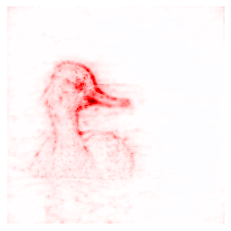

In [10]:
# 目前解釋圖只有辦法存原論文的OAO
# 原始解釋圖
show_expl_title(org_expl, cm= 'seismic')
im_ori = show_expl_title_return_im(org_expl, cm='seismic')
print('ori_exp')

### 擾動解釋圖

adv_expl


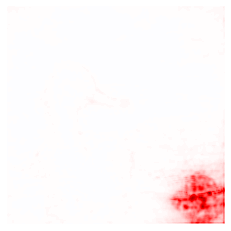

In [11]:
# 擾動解釋圖
show_expl_title(adv_expl, cm = 'seismic')
# autumn, bone, cool, copper, flag, gray, hot, hsv, inferno, 
# jet, magma, pink, plasma, prism, spring, summer, viridis, winter,
im_adv = show_expl_title_return_im(adv_expl, cm='seismic')

print('adv_expl')

### Metric

In [12]:
adv_expl_np = adv_expl[0].cpu().detach().numpy()
org_expl_np = org_expl[0].cpu().detach().numpy()
print('ssim')
print('ori and adv :', structural_similarity(adv_expl_np, org_expl_np, multichannel=True))
print('ori and mal :', structural_similarity(org_expl_np, target_mtx, multichannel=True))
print('adv and mal :', structural_similarity(adv_expl_np, target_mtx, multichannel=True))

print('mse')
print('ori and adv :', mean_squared_error(adv_expl_np, org_expl_np))
print('ori and mal :', mean_squared_error(org_expl_np, target_mtx))
print('adv and mal :', mean_squared_error(adv_expl_np, target_mtx))

print('psnr')
print('ori and adv :', peak_signal_noise_ratio(adv_expl_np, org_expl_np))
print('ori and mal :', peak_signal_noise_ratio(org_expl_np, target_mtx))
print('adv and mal :', peak_signal_noise_ratio(adv_expl_np, target_mtx))

ssim
ori and adv : 0.9999858133039348
ori and mal : 0.9987597005320618
adv and mal : 0.9988096511775124
mse
ori and adv : 6.053877731079369e-09
ori and mal : 4.97524373118641e-07
adv and mal : 4.781806771859022e-07
psnr
ori and adv : 82.17966354646998
ori and mal : 63.03185638834532
adv and mal : 63.20407977281489


/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  app.launch_new_instance()


top10_adv top10_adv_red


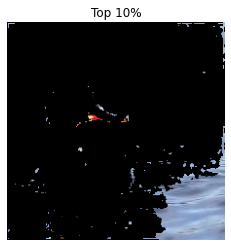

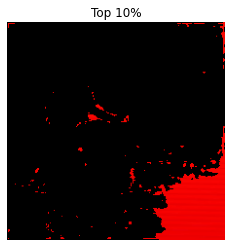

In [13]:
topk = 90
im = Image.open(img)
im2 = np.array(im)
im2 = np.resize(im2,(224,224,3))
adv_expl_np = adv_expl.detach().cpu().numpy()
mask = adv_expl_np > np.percentile(adv_expl_np, topk) #取出指定容器內幾%的值(pr值)
im2[~mask[0]] = 0
ShowImage(im2, 'Top 10%')

im = Image.open(red)
im2 = np.array(im)
im2 = np.resize(im2,(224,224,3))
mask = adv_expl_np > np.percentile(adv_expl_np, topk) #取出指定容器內幾%的值(pr值)
im2[~mask[0]] = 0
ShowImage(im2, 'Top 10%')
print('top10_adv','top10_adv_red')